## Library Imports

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [174]:
import pymc as pm
import arviz as az

## Data Import and Merging

In [175]:
drivers_df = pd.read_csv('data/drivers.csv')
drivers_df = drivers_df[['driverId', 'forename', 'surname']]
drivers_df.head()

,driverId,forename,surname
0,1,Lewis,Hamilton
1,2,Nick,Heidfeld
2,3,Nico,Rosberg
3,4,Fernando,Alonso
4,5,Heikki,Kovalainen


In [176]:
constructor_df = pd.read_csv('data/constructors.csv')
constructor_df = constructor_df[['constructorId', 'name']]
constructor_df.head()

,constructorId,name
0,1,McLaren
1,2,BMW Sauber
2,3,Williams
3,4,Renault
4,5,Toro Rosso


In [177]:
results = pd.read_csv('data/results.csv')
results = results[['raceId', 'driverId', 'constructorId', 'grid', 'position', 'milliseconds', 'statusId']]
results = results[results['statusId'] == 1]
results.head()

,raceId,driverId,constructorId,grid,position,milliseconds,statusId
0,18,1,1,1,1,5690616,1
1,18,2,2,5,2,5696094,1
2,18,3,3,7,3,5698779,1
3,18,4,4,11,4,5707797,1
4,18,5,1,3,5,5708630,1


In [178]:
races_df = pd.read_csv('data/races.csv')
races_df = races_df[['raceId', 'year']]
races_df.head()

,raceId,year
0,1,2009
1,2,2009
2,3,2009
3,4,2009
4,5,2009


In [179]:
results = pd.merge(results, races_df, on='raceId', how='left')
results.head()

,raceId,driverId,constructorId,grid,position,milliseconds,statusId,year
0,18,1,1,1,1,5690616,1,2008
1,18,2,2,5,2,5696094,1,2008
2,18,3,3,7,3,5698779,1,2008
3,18,4,4,11,4,5707797,1,2008
4,18,5,1,3,5,5708630,1,2008


In [180]:
results = pd.merge(results, drivers_df, on='driverId', how='left')
results['driverName'] = results['forename'] + ' ' + results['surname']
results.head()

,raceId,driverId,constructorId,grid,position,milliseconds,statusId,year,forename,surname,driverName
0,18,1,1,1,1,5690616,1,2008,Lewis,Hamilton,Lewis Hamilton
1,18,2,2,5,2,5696094,1,2008,Nick,Heidfeld,Nick Heidfeld
2,18,3,3,7,3,5698779,1,2008,Nico,Rosberg,Nico Rosberg
3,18,4,4,11,4,5707797,1,2008,Fernando,Alonso,Fernando Alonso
4,18,5,1,3,5,5708630,1,2008,Heikki,Kovalainen,Heikki Kovalainen


In [181]:
results = pd.merge(results, constructor_df, on='constructorId', how='left')
results.rename(columns={'name': 'constructorName'}, inplace=True)
results.drop(['raceId', 'driverId', 'constructorId', 'statusId', 'forename', 'surname'], axis=1, inplace=True)
results.head()

,grid,position,milliseconds,year,driverName,constructorName
0,1,1,5690616,2008,Lewis Hamilton,McLaren
1,5,2,5696094,2008,Nick Heidfeld,BMW Sauber
2,7,3,5698779,2008,Nico Rosberg,Williams
3,11,4,5707797,2008,Fernando Alonso,Renault
4,3,5,5708630,2008,Heikki Kovalainen,McLaren


## Feature Preparation

In [182]:
results = results[results['milliseconds'] != '\\N']

In [183]:
# convert the driver name and construct name strings to integers that can be easily mapped back to the strings
drivers = results['driverName'].astype("category").cat.codes.to_numpy(copy=True)
constructors = (results['constructorName'].astype(str) + '_' + results['year'].astype(str)).astype("category").cat.codes.to_numpy(copy=True)

grid = results['grid'].to_numpy(copy=True)
position = results['position'].astype(int).to_numpy(copy=True)
time = results['milliseconds'].astype(int).to_numpy(copy=True)

In [184]:
# create maps that allow for easy access of driver and constructor names based on the indices of driver and constructor responses
driver_id_map = dict(enumerate(results["driverName"].astype("category").cat.categories))
constructor_id_map = dict(enumerate((results['constructorName'].astype(str) + '_' + results['year'].astype(str)).astype("category").cat.categories))

## Model Creation

In [185]:
with pm.Model() as m:
    beta_driver = pm.Normal("driver", mu=0, sigma=1, shape=len(np.unique(drivers)))
    beta_constructor  = pm.Normal("constructor", mu=0, sigma=1, shape=len(np.unique(constructors)))

    beta_grid = pm.Normal('beta_grid', mu=0, sigma=10)

    mu = - beta_driver[drivers] - beta_constructor[constructors] + beta_grid * grid

    tau = pm.Gamma("tau", 0.001, 0.001)

    obs = pm.Normal("time", mu=mu, tau=tau, observed=np.log(time))

    trace = pm.sample(draws=2000, tune=500)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [driver, constructor, beta_grid, tau]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 53 seconds.


In [186]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
driver[0],-4.664,0.549,-5.752,-3.603,0.005,0.006,10516.0,6464.0,1.0
driver[1],-0.822,0.938,-2.742,0.947,0.007,0.013,16596.0,5031.0,1.0
driver[2],-0.110,0.915,-1.980,1.594,0.007,0.012,15689.0,5016.0,1.0
driver[3],-0.077,0.950,-1.878,1.809,0.008,0.012,15192.0,5233.0,1.0
driver[4],-10.058,0.362,-10.740,-9.335,0.004,0.004,7925.0,6278.0,1.0
...,...,...,...,...,...,...,...,...,...
constructor[678],-1.730,0.700,-3.122,-0.376,0.006,0.008,12122.0,6154.0,1.0
constructor[679],-1.793,0.797,-3.308,-0.148,0.007,0.010,14074.0,5817.0,1.0
constructor[680],-0.979,0.814,-2.599,0.630,0.006,0.011,16134.0,5621.0,1.0
beta_grid,0.700,0.010,0.681,0.718,0.000,0.000,2537.0,4109.0,1.0


## Top 10 Drivers

In [187]:
posterior_driver = trace.posterior["driver"].mean(dim=("chain", "draw")).values
top10 = np.argsort(posterior_driver)[:10]
for i in top10:
    print(f'{driver_id_map[i]}: {posterior_driver[i] * -1}')

Ayrton Senna: 10.297458986851128
Alain Prost: 10.058195830724772
Michael Schumacher: 9.924275265736757
Lewis Hamilton: 9.526391704251166
Nico Rosberg: 9.434065368842434
Sebastian Vettel: 9.017765943378958
Max Verstappen: 8.953458811256501
Gerhard Berger: 8.93637777608164
Nelson Piquet: 8.853987809413718
Fernando Alonso: 8.82389001210435


## Constructor Strength Analysis

In [188]:
posterior_constructor = trace.posterior["constructor"].mean(dim=("chain", "draw")).values

constructor_strengths = {}

for k,v in constructor_id_map.items():
    constr, year = v.split('_')
    if not constr in constructor_strengths:
        constructor_strengths[constr] = {'year': [], 'strength': []}
    constructor_strengths[constr]['year'].append(int(year))
    constructor_strengths[constr]['strength'].append(float(-1.0 * posterior_constructor[k]))

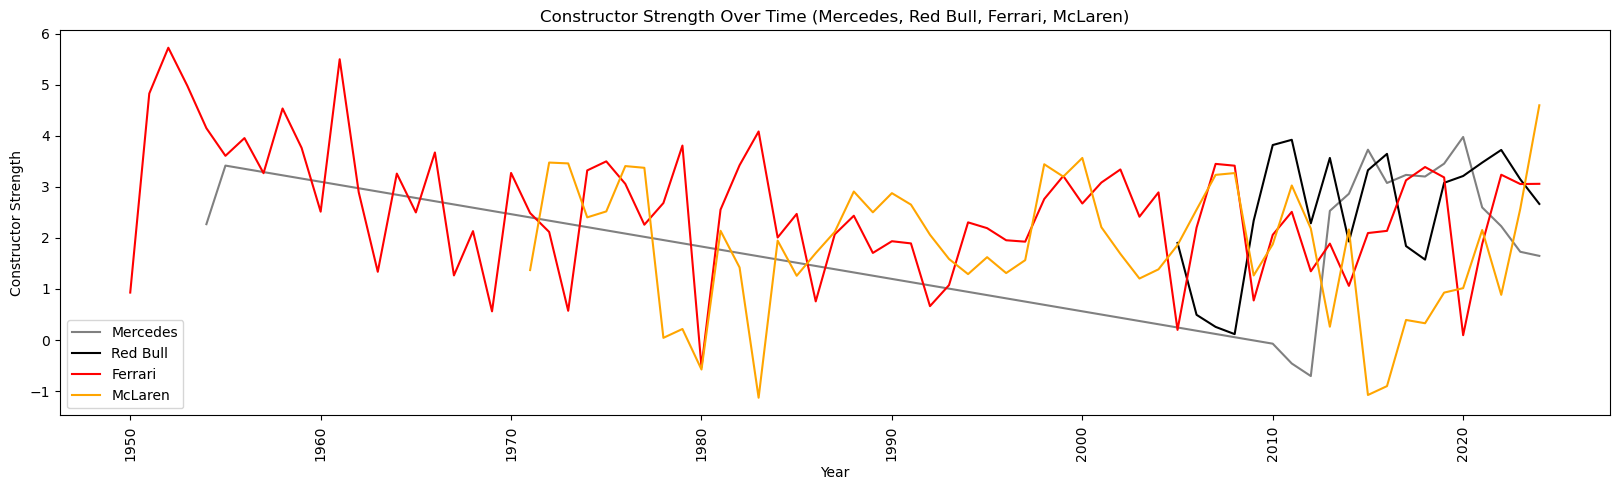

In [189]:
plt.figure(figsize=(20, 5))
plt.plot(constructor_strengths['Mercedes']["year"], constructor_strengths['Mercedes']["strength"], label="Mercedes", color='grey')
plt.plot(constructor_strengths['Red Bull']["year"], constructor_strengths['Red Bull']["strength"], label="Red Bull", color='black')
plt.plot(constructor_strengths['Ferrari']["year"], constructor_strengths['Ferrari']["strength"], label="Ferrari", color='red')
plt.plot(constructor_strengths['McLaren']["year"], constructor_strengths['McLaren']["strength"], label="McLaren", color='orange')
plt.xticks(rotation=90)
plt.title('Constructor Strength Over Time (Mercedes, Red Bull, Ferrari, McLaren)')
plt.xlabel('Year')
plt.ylabel('Constructor Strength')
plt.legend(loc='lower left')
plt.show()

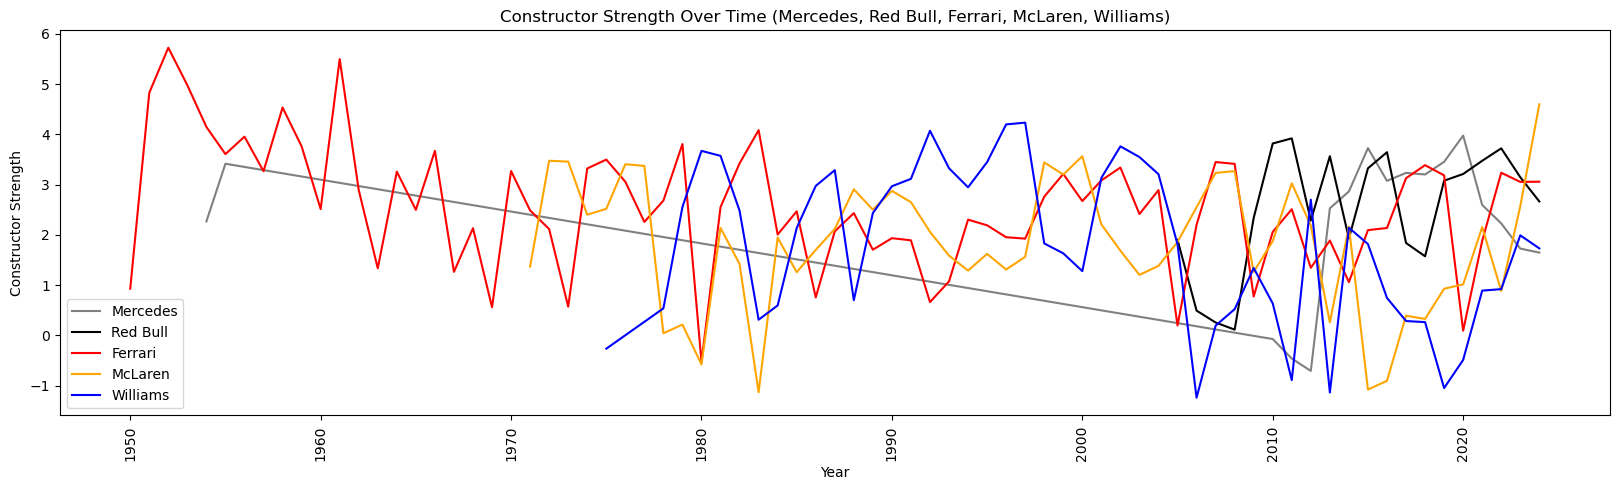

In [190]:
plt.figure(figsize=(20, 5))
plt.plot(constructor_strengths['Mercedes']["year"], constructor_strengths['Mercedes']["strength"], label="Mercedes", color='grey')
plt.plot(constructor_strengths['Red Bull']["year"], constructor_strengths['Red Bull']["strength"], label="Red Bull", color='black')
plt.plot(constructor_strengths['Ferrari']["year"], constructor_strengths['Ferrari']["strength"], label="Ferrari", color='red')
plt.plot(constructor_strengths['McLaren']["year"], constructor_strengths['McLaren']["strength"], label="McLaren", color='orange')
plt.plot(constructor_strengths['Williams']["year"], constructor_strengths['Williams']["strength"], label="Williams", color='blue')
plt.xticks(rotation=90)
plt.title('Constructor Strength Over Time (Mercedes, Red Bull, Ferrari, McLaren, Williams)')
plt.xlabel('Year')
plt.ylabel('Constructor Strength')
plt.legend(loc='lower left')
plt.show()

## 2024 Japanese Grand Prix Simulation

In [191]:
# 2024 Japanese Grand Prix
driver_to_idx_map = {v: k for k,v in driver_id_map.items()}
constructor_to_idx_map = {v: k for k,v in constructor_id_map.items()}

In [192]:
def compute_race_time(d, c, g):
    d_idx = driver_to_idx_map[d]
    c_idx = constructor_to_idx_map[c]
    skills = trace.posterior['driver'].values[:,:,d_idx] * -1
    strengths = trace.posterior['constructor'].values[:,:,c_idx] * -1
    grids = trace.posterior['beta_grid'].values
    taus = trace.posterior['tau'].values
    mus = - skills - strengths + grids * g
    return float(np.exp(np.random.normal(mus, 1 / np.sqrt(taus))).mean())

In [193]:
qualifying_list = [
    ('Max Verstappen', 'Red Bull_2024', 1),
    ('Sergio Pérez', 'Red Bull_2024', 2),
    ('Lando Norris', 'McLaren_2024', 3),
    ('Carlos Sainz', 'Ferrari_2024', 4),
    ('Fernando Alonso', 'Aston Martin_2024', 5),
    ('Oscar Piastri', 'McLaren_2024', 6),
    ('Lewis Hamilton', 'Mercedes_2024', 7),
    ('Charles Leclerc', 'Ferrari_2024', 8),
    ('George Russell', 'Mercedes_2024', 9),
    ('Yuki Tsunoda', 'RB F1 Team_2024', 10),
    ('Daniel Ricciardo', 'RB F1 Team_2024', 11),
    ('Nico Hülkenberg', 'Haas F1 Team_2024', 12),
    ('Valtteri Bottas', 'Sauber_2024', 13),
    ('Alexander Albon', 'Williams_2024', 14),
    ('Esteban Ocon', 'Alpine F1 Team_2024', 15),
    ('Lance Stroll', 'Aston Martin_2024', 16),
    ('Pierre Gasly', 'Alpine F1 Team_2024', 17),
    ('Kevin Magnussen', 'Haas F1 Team_2024', 18),
    ('Logan Sargeant', 'Williams_2024', 19),
    ('Guanyu Zhou', 'Sauber_2024', 20)
]
race_finish = []
for d,c,g in qualifying_list:
    race_finish.append((d, compute_race_time(d, c, g)))

race_finish = sorted(race_finish, key=lambda x: x[1])

for i in range(len(race_finish)):
    print(f"{i + 1}: {race_finish[i][0]}")

1: Max Verstappen
2: Lando Norris
3: Carlos Sainz
4: Sergio Pérez
5: Lewis Hamilton
6: Charles Leclerc
7: Fernando Alonso
8: Oscar Piastri
9: George Russell
10: Daniel Ricciardo
11: Nico Hülkenberg
12: Valtteri Bottas
13: Yuki Tsunoda
14: Alexander Albon
15: Esteban Ocon
16: Lance Stroll
17: Pierre Gasly
18: Kevin Magnussen
19: Logan Sargeant
20: Guanyu Zhou
